In [156]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import seaborn as sns

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/HD/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/HD/test.csv').drop(columns=['SAMPLE_ID'])

Target: CI_HOUR (대기시간)

# EDA

In [157]:
train['SHIP_TYPE_CATEGORY'].unique()

array(['Container', 'Bulk', 'Cargo', 'Tanker'], dtype=object)

<ipython-input-140-9db3a5273761>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train.corr()


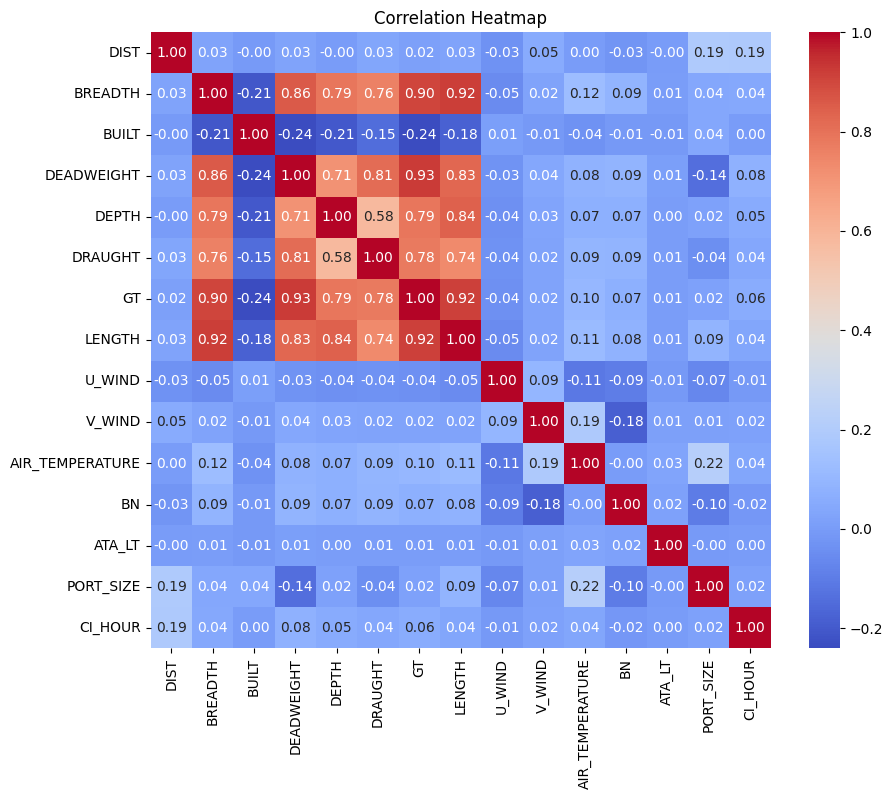

In [140]:
# 상관 행렬 계산
correlation_matrix = train.corr()

# 히트맵으로 상관 관계 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Data Pre-processing

In [141]:
train.isnull().sum()

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                163688
V_WIND                163688
AIR_TEMPERATURE       164630
BN                    163688
ATA_LT                     0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

In [142]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

Encoding features: 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


# 모델 학습 및 특성 중요도 확인

Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2912
[LightGBM] [Info] Number of data points in the train set: 391939, number of used features: 26
[LightGBM] [Info] Start training from score 61.940835


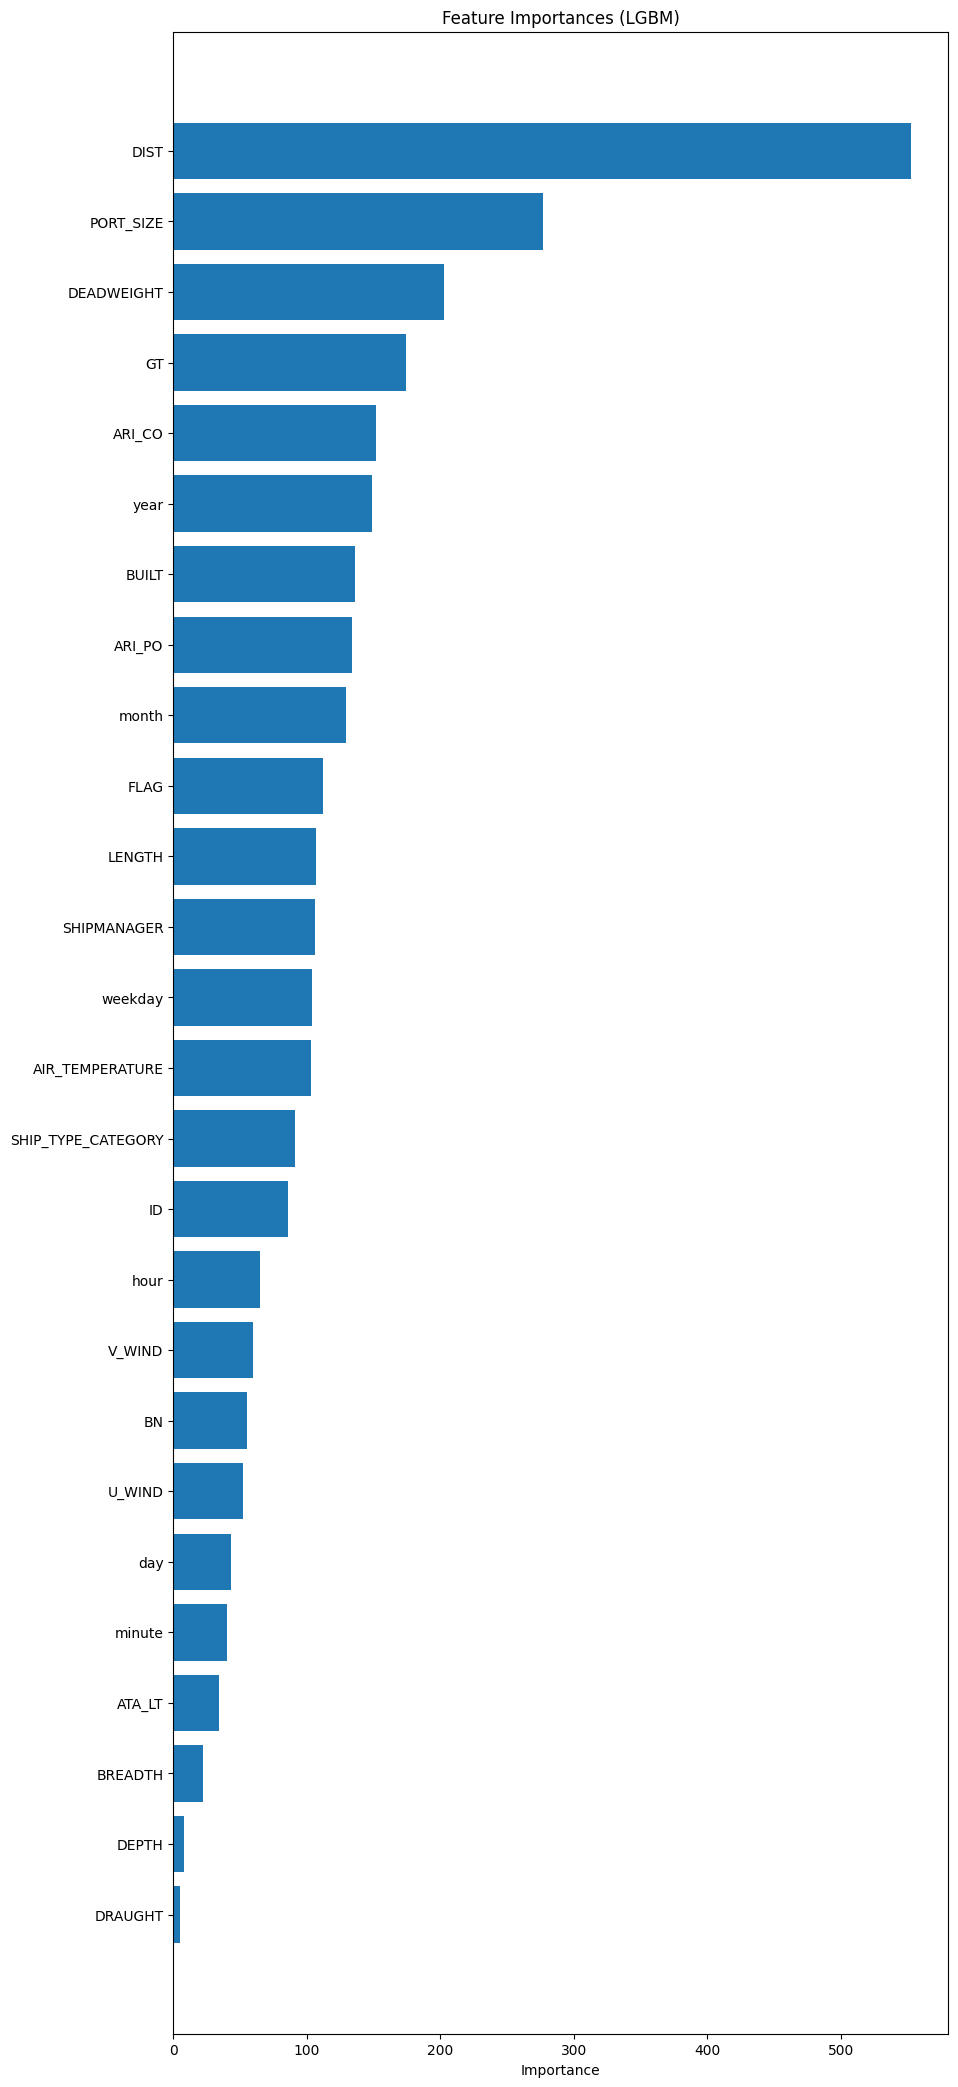

In [143]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

# 특성 중요도로부터 Feature Selection

In [150]:
threshold = 85
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [151]:
X_train_reduced

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BUILT,DEADWEIGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,PORT_SIZE,year,month,hour,weekday
0,17,21,2,30.881018,24710,24,24300,16700,180.0,686,89,-0.29491,-0.263849,18.862968,2.706992,0.002615,2018,12,21,0
1,7,81,0,0.000000,23140,13,35900,23500,180.0,4720,74,-0.29491,-0.263849,18.862968,2.706992,0.000217,2014,9,6,1
2,4,14,2,0.000000,19009,12,146000,140000,370.0,1370,73,-0.29491,-0.263849,18.862968,2.706992,0.001614,2015,2,22,1
3,8,101,2,0.000000,24048,18,6910,5400,120.0,3809,5,-3.18000,-1.610000,6.700000,2.629350,0.000356,2020,1,4,4
4,17,21,2,27.037650,911,10,116000,96600,300.0,1687,67,-0.33000,-3.280000,25.600000,2.495953,0.002615,2020,1,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,8,66,2,0.000000,23490,27,6820,4820,110.0,2562,20,-0.29491,-0.263849,18.862968,2.706992,0.000552,2017,6,5,1
391935,17,21,0,5.884603,10196,12,3160,1600,80.0,2400,124,-0.66000,0.970000,27.300000,1.253491,0.002615,2019,10,0,2
391936,21,61,0,70.660241,8823,8,60300,34800,200.0,6106,102,-3.44000,7.990000,21.100000,4.766257,0.000155,2021,3,22,1
391937,19,35,2,9.448179,9246,29,23800,16900,170.0,1771,22,-0.29491,-0.263849,18.862968,2.706992,0.000990,2015,1,7,3


In [152]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['DIST', 'LENGTH', 'AIR_TEMPERATURE', 'PORT_SIZE']

scaler = StandardScaler()
X_train_reduced[cols_to_scale] = scaler.fit_transform(X_train_reduced[cols_to_scale])
X_test_reduced[cols_to_scale] = scaler.fit_transform(X_test_reduced[cols_to_scale])

In [153]:
X_train_reduced

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BUILT,DEADWEIGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,PORT_SIZE,year,month,hour,weekday
0,17,21,2,0.373515,24710,24,24300,16700,-0.331094,686,89,-0.29491,-0.263849,4.794577e-16,2.706992,2.075833,2018,12,21,0
1,7,81,0,-0.624901,23140,13,35900,23500,-0.331094,4720,74,-0.29491,-0.263849,4.794577e-16,2.706992,-0.787562,2014,9,6,1
2,4,14,2,-0.624901,19009,12,146000,140000,2.173068,1370,73,-0.29491,-0.263849,4.794577e-16,2.706992,0.880664,2015,2,22,1
3,8,101,2,-0.624901,24048,18,6910,5400,-1.121882,3809,5,-3.18000,-1.610000,-1.641458e+00,2.629350,-0.621043,2020,1,4,4
4,17,21,2,0.249255,911,10,116000,96600,1.250482,1687,67,-0.33000,-3.280000,9.091985e-01,2.495953,2.075833,2020,1,7,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,8,66,2,-0.624901,23490,27,6820,4820,-1.253680,2562,20,-0.29491,-0.263849,4.794577e-16,2.706992,-0.387543,2017,6,5,1
391935,17,21,0,-0.434645,10196,12,3160,1600,-1.649074,2400,124,-0.66000,0.970000,1.138623e+00,1.253491,2.075833,2019,10,0,2
391936,21,61,0,1.659619,8823,8,60300,34800,-0.067498,6106,102,-3.44000,7.990000,3.018994e-01,4.766257,-0.861057,2021,3,22,1
391937,19,35,2,-0.319431,9246,29,23800,16900,-0.462892,1771,22,-0.29491,-0.263849,4.794577e-16,2.706992,0.135189,2015,1,7,3


# K-Fold Model Fitting & Validation

In [154]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2784
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 20
[LightGBM] [Info] Start training from score 62.157481


Processing folds:  20%|██        | 1/5 [00:04<00:18,  4.62s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2786
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 20
[LightGBM] [Info] Start training from score 61.815772


Processing folds:  40%|████      | 2/5 [00:10<00:15,  5.28s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2784
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 20
[LightGBM] [Info] Start training from score 61.753606


Processing folds:  60%|██████    | 3/5 [00:14<00:09,  4.80s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2781
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 20
[LightGBM] [Info] Start training from score 61.959403


Processing folds:  80%|████████  | 4/5 [00:18<00:04,  4.55s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2781
[LightGBM] [Info] Number of data points in the train set: 313552, number of used features: 20
[LightGBM] [Info] Start training from score 62.017911


Processing folds: 100%|██████████| 5/5 [00:24<00:00,  4.95s/it]

Validation : MAE scores for each fold: [55.01792798267568, 56.564550202423064, 56.144070844883956, 55.540568969685154, 55.223938927313306]
Validation : MAE: 55.698211385396235


# 모든 Feature

In [124]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train), total=5, desc="Processing folds"):
    X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(test)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2914
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 26
[LightGBM] [Info] Start training from score 62.157481


Processing folds:  20%|██        | 1/5 [00:05<00:23,  5.83s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2916
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 26
[LightGBM] [Info] Start training from score 61.815772


Processing folds:  40%|████      | 2/5 [00:10<00:15,  5.30s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2914
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 26
[LightGBM] [Info] Start training from score 61.753606


Processing folds:  60%|██████    | 3/5 [00:17<00:11,  5.99s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2911
[LightGBM] [Info] Number of data points in the train set: 313551, number of used features: 26
[LightGBM] [Info] Start training from score 61.959403


Processing folds:  80%|████████  | 4/5 [00:23<00:05,  5.87s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2911
[LightGBM] [Info] Number of data points in the train set: 313552, number of used features: 26
[LightGBM] [Info] Start training from score 62.017911


Processing folds: 100%|██████████| 5/5 [00:28<00:00,  5.79s/it]

Validation : MAE scores for each fold: [55.23755133605265, 56.34863665441285, 56.22264837810586, 55.6295501297152, 55.34999338079847]
Validation : MAE: 55.75767597581701


In [155]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/HD/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./baseline_submit.csv', index=False)